In [65]:
## Import Necessary Libraries

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import RNA
import json
import pandas as pd
import forgi.visual.mplotlib as fvm
import forgi
import matplotlib.pyplot as plt
import webbrowser
import numpy as np
import networkx as nx
import seaborn as sns


In [66]:
#Example: Load in Train Data and Set Index to 0
train = pd.read_json('stanford-covid-vaccine/train.json', lines=True)
idx = 0
indices = [i for i in range(len(train.iloc[idx]['structure']))]
print(f"Sequence: {train.iloc[idx]['sequence']}\nStructure: {train.iloc[idx]['structure']}\nIndex: {indices}")

Sequence: GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
Structure: .....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


In [67]:
#Split into multiple secondary structures

def check(seq, struc):
    i = 0
    while True:
        i+=1
        if struc[i] == ')':
            for x in range(len(struc[i:])):
                idx = i+x
                if struc[i+x] == '(':
                    return idx, struc[:idx], struc
                    break


def get_all_portions(seq, struc):
    a = []
    try:
        copy = struc
        while True:
            idx, new, _ = check(seq, copy)
            a.append(new)
            copy = copy[idx:]
    except:
        a.append(copy)

    return a


In [69]:

def visualize(seq, struc):
    viz = f'http://nibiru.tbi.univie.ac.at/forna/forna.html?id=fasta&file=%3Eheader%5Cn{seq}%5Cn{struc}'
    webbrowser.open(viz)

def clean_ends(splits):
    all_len = len(splits)
    copy_splits = splits
    for idx, split in enumerate(splits):
        first = split.find('(')
        last = split[::-1].find(')')
        copy = split
        copy = copy[::-1][last:]
        copy = copy[::-1][first:]
        copy_splits[idx] = copy
    return copy_splits[:all_len]
        

eg_seq = train.iloc[idx]['sequence']
eg_struc = train.iloc[idx]['structure']

visualize(eg_seq, eg_struc)


new_splits = clean_ends(get_all_portions(eg_seq, eg_struc))
print(eg_struc)
print(new_splits)


.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
['((((((.......)))).))', '((.....((..((((((....))))))..)).....))', '(((((((....)))))))']


In [70]:
def base_pairing(any_splits):
    all_things = []
    for idx, split in enumerate(any_splits):
        all_open = [x for x, g in enumerate(split) if g=='(']
        all_close = [x for x, g in enumerate(split) if g==')']
        middle_bracket = [max(all_open), min(all_close)]
        all_things.append(middle_bracket)
    return all_things

def find_bonds(seq, struc):
    splits = clean_ends(get_all_portions(seq, struc))
    middles = base_pairing(splits)
    
    for idx, middle in enumerate(middles):
        padding_left=int(struc.find(splits[idx]))
        new_vals = [middle[0]+padding_left, middle[1]+padding_left]
        middles[idx] = new_vals

    return middles, struc, splits


def test_pair(seq, struc, idx_type=0):
    bondage = []
    middles, copy_struc, splits = find_bonds(seq, struc)
    left, right = middles[idx_type]
    while True:
        try:
            if copy_struc[left] == '(' and copy_struc[right] == ')':
                bondage.append([left, right])
                left-=1
                right+=1
            elif copy_struc[left] == '(' and copy_struc[right] == '.':
                right +=1
            elif copy_struc[left] == '.' and copy_struc[right] == ')':
                left -=1
            elif copy_struc[left] == '.' and copy_struc[right] == '.':
                left -=1
                right +=1
            else:
                break
        except:
            break

    return middles, copy_struc, splits, bondage


In [71]:
def get_sequence_bonds(idx):


    eg_seq = train.iloc[idx]['sequence']
    eg_struc = train.iloc[idx]['structure']

    symmetric_bonds = []
    repl_struc = ''


    for i in range(len(clean_ends(get_all_portions(eg_seq, eg_struc)))):
        eg_middles, repl_struc, eg_splits, eg_bondage = test_pair(eg_seq, eg_struc, i)
        symmetric_bonds += eg_bondage



    try:
        while ('(' or ')') in repl_struc:
            split_struc = [i for i in repl_struc]

            for coord in symmetric_bonds:
                l, r = coord
                split_struc[l] = '.'
                split_struc[r] = '.'

            repl_struc = ''.join(split_struc)
            _, _, _, final_bondage = test_pair(eg_seq, repl_struc)
            symmetric_bonds += final_bondage
    except:
        pass

    all_bonds = [list(x) for x in set(tuple(x) for x in symmetric_bonds)]

    # print(eg_struc)
    # print(repl_struc)
    # print(len(all_bonds))
    # print(len([char for char in eg_struc if char == '(']))
    return all_bonds, eg_struc, eg_seq


GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................
[[27, 62], [74, 79], [26, 63], [10, 18], [34, 55], [72, 81], [42, 47], [73, 80], [6, 23], [41, 48], [33, 56], [40, 49], [9, 19], [5, 24], [39, 50], [8, 20], [71, 82], [7, 21], [69, 84], [70, 83], [38, 51], [37, 52], [68, 85]]


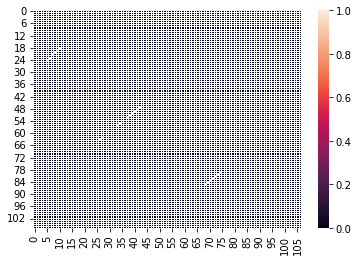

In [72]:
dataset_adjacency = {key: [] for key in range(len(train))}

for idx in range(len(train)):
    flag = ''
    eg_struc = train.iloc[idx]['structure']
    all_bonds, check_struc, check_seq = get_sequence_bonds(idx)
    if len(all_bonds) != len([char for char in eg_struc if char == '(']):
        flag = 'hmm sus'
    else:
        dataset_adjacency[idx] = [check_seq, check_struc, all_bonds]
        flag = 'All structures are accounted for'        

print(dataset_adjacency[0][0])
print(dataset_adjacency[0][1])
print(dataset_adjacency[0][2])
visualize(dataset_adjacency[0][0], str(dataset_adjacency[0][1]))

def heatmap(dict_data, idx):
    seq, struc, bonds = dict_data[idx]
    adjacency_matrix = np.zeros((len(seq), len(seq)))
    for coord in bonds:
        x, y = coord
        adjacency_matrix[y][x] = 1
        
    # plt.imshow(adjacency_matrix)
    ax = sns.heatmap(adjacency_matrix, linewidth=0.5)
    plt.show()

##Validate through vizualize function and http://rna.tbi.univie.ac.at/RNAfold/5hZpfUnj2D/sequence1_dp.pdf right side all black
heatmap(dataset_adjacency, 0)

In [155]:
import operator
from operator import itemgetter

def convert_bp(dataset, idx):
    all_bp = dataset[idx][0]
    # print(all_bp)
    stems = dataset[idx][2]
    copy_stems = sorted(stems, key=itemgetter(0))
    # print(copy_stems)

    main = []
    for j, pairs in enumerate(copy_stems):
        emp = []
        for c, _ in enumerate(pairs):
            x = int(copy_stems[j][c])
            curr = all_bp[x]
            emp.append(curr)
        main.append(emp)
    
    return copy_stems, main

In [156]:
## TITLE: Let's focus on the degredation statistics purely, regardless of the secondary structures present. 
## E = Non-Basepaired
## H = Hairpin Loop
## I = Internal Loop
## M = Multibranch Loop
## X = Exterior Loop
## S = Stems

test = pd.read_json('stanford-covid-vaccine/test.json', lines=True)
check = train['predicted_loop_type'][0]
# print(check)
# print(dataset_adjacency[0][0])
# print(dataset_adjacency[0][1])
# print(dataset_adjacency[0][2])

# heatmap(dataset_adjacency, 0)

bp = ['AU', 'CG', 'GC', 'UA', 'GU', 'UG']
vals_stem = [[-0.9, -1.8, -2.3, -1.1, -0.5, -0.7],
        [-2.1, -2.9, -3.4, -2.3, -1.5, -1.5],
        [-1.7, -2.0, -2.9, -1.8, -1.3, -1.5],
        [-0.9, -1.7, -2.1, -0.9, -0.7, -0.5],
        [-0.9, -1.7, -2.1, -0.9, -0.7, -0.5],
        [-0.9, -1.7, -2.1, -0.9, -0.7, -0.5]]

ss = [i+1 for i in range(8)]
        ### I   B    H
vals_ss = [[0, 3.3, 0],
        [0.8, 5.2, 0],
        [1.3, 6, 7.4],
        [1.7, 6.7, 5.9],
        [2.1, 7.4, 4.4],
        [2.5, 8.2, 4.3],
        [2.6, 9.1, 4.1],
        [2.8, 10, 4.1]]

turner_bp_bottom = {bp[idx]: vals_stem[idx] for idx in range(len(bp))}
turner_ss_freq = {ss[idx]: vals_ss[idx] for idx in range(len(ss))}

ss_type = ['S', 'E', 'H', 'I', 'B', 'M', 'X']

def stem_energy(dataset, y):

        stem_indices, stem_bases = convert_bp(dataset, y)
        first_indices_check = [i[0] for i in stem_indices]
        stem_bases = [''.join(i) for i in stem_bases]
        # print(stem_bases)
        # print(first_indices_check)

        all_scores = []
        for x in range(len(stem_bases)):
                bottom = stem_bases[x]
                try:
                        if first_indices_check[x+1] == int(first_indices_check[x] + 1):
                                top = stem_bases[x+1]
                        else:
                                top = stem_bases[x]
                except:
                        break
                score = turner_bp_bottom[top][bp.index(bottom)]
                all_scores.append(score)

        return all_scores

stem_energy(dataset_adjacency, 0)



['AU', 'GC', 'CG', 'UA', 'CG', 'UG', 'GC', 'GC', 'GC', 'UA', 'UA', 'UA', 'CG', 'UG', 'AU', 'GC', 'GC', 'UA', 'UA', 'AU', 'GC', 'AU', 'GC']
[5, 6, 7, 8, 9, 10, 26, 27, 33, 34, 37, 38, 39, 40, 41, 42, 68, 69, 70, 71, 72, 73, 74]


[-1.7,
 -3.4,
 -1.7,
 -2.3,
 -1.7,
 -0.5,
 -2.9,
 -2.9,
 -2.1,
 -0.9,
 -0.9,
 -2.3,
 -1.7,
 -0.7,
 -1.7,
 -2.9,
 -2.1,
 -0.9,
 -1.1,
 -1.7,
 -2.3,
 -1.7]

In [173]:

def zuckers(ss, data, idx):
    init_ss = {key: [] for key in ss_type}
    ss_seq = ss['predicted_loop_type'].iloc[idx]
    for x, bp in enumerate(ss_seq):
        init_ss[bp].append(x)
    all_indices = list(init_ss.values())
    
    # print('Init', init_ss)
    for key, value in init_ss.items():
        new = []
        curr = []
        for j, x in enumerate(value):
            if j == int(len(value)-1):
                curr.append(x)
                new.append(curr)
            elif x == value[j+1]-1:
                curr.append(x)
            elif x != value[j+1]-1:
                curr.append(x)
                new.append(curr)
                curr = []
            

        init_ss[key] = new    
        
    return init_ss

In [174]:
import math

## TODO: Add the dangling and external loop turner laws

def ss_free_energy(init_d, dataset, y):
    ss_sequence = zuckers(init_d, dataset, y)
    # print('After Removing', ss_sequence)

    # print(ss_sequence)
    all_keys = [i for i in ss_sequence.keys()][1:]
    all_vals = [i for i in ss_sequence.values()][1:]


    ss_check = dict(zip(all_keys, all_vals))
    for key, vals in ss_check.items():
        if key == 'H':
            col = 2
        elif key == 'I':
            col = 0
        elif key == 'B':
            col = 1
        else:
            col = None
        try:
            all_lens = [len(i) for i in vals]
            all_td = [turner_ss_freq[i][col] for i in all_lens]
        except:
            all_td = []
        ss_check[key] = all_td
    
    return ss_check

# stem_check = stem_energy(dataset_adjacency, 0)
# ss_check = ss_free_energy(train, dataset_adjacency, 0)
# # print(ss_check)

# total_free_energy = sum(stem_check) + sum([sum(i) for i in list(ss_check.values())])
# # print(total_free_energy)


In [175]:
def external_ss_energy(init_d, dataset, y):

    xPossibles = ['AU', 'CG', 'GC', 'GU', 'UA', 'UG']
    bp_ord = ['A', 'C', 'G', 'U']

    EThreePrime = [[-0.8, -0.5, -0.8, -0.6],
                [-1.7, -0.8, -1.7, -1.2],
                [-1.1, -0.4, -1.3, -0.6],
                [-0.8, -0.5, -0.8, -0.6],
                [-0.7, -0.1, -0.7, -0.1],
                [-0.7, -0.1, -0.7, -0.1]]

    EFivePrime = [[-0.3, -0.1, -0.2, -0.2],
                [-0.2, -0.3, -0.0, -0.0],
                [-0.5, -0.3, -0.2, -0.1],
                [-0.3, -0.1, -0.2, -0.2],
                [-0.3, -0.3, -0.4, -0.2],
                [-0.3, -0.3, -0.4, -0.2]]
                


    DangleThreePrime = {xPossibles[idx]: EThreePrime[idx] for idx in range(len(xPossibles))}
    DangleFivePrime = {xPossibles[idx]: EFivePrime[idx] for idx in range(len(xPossibles))}

    ss_sequence = zuckers(init_d, dataset, y)
    stem_indices, stem_bases = convert_bp(dataset, y)
    stem_bases = [''.join(i) for i in stem_bases]
    # print(stem_indices)

    seq_curr = dataset[y][0]
    struc_curr = dataset[y][1]
    ind_curr = dataset[y][2]
    lasts = [i[1] for i in stem_indices]
    firsts = [i[0] for i in stem_indices]
    external_energies = []

    # print('Stems', stem_bases)
    # print('Indices', stem_indices)
    # print('Sequence', seq_curr)
    # print('Structure', struc_curr)
    # print('Pairs', ind_curr)

    # print(firsts)
    # print(lasts)

    # print(ind_curr)

    for i in ss_sequence['X']:
        dangling_bp = i[0]
        # print(dangling_bp)
        idx_bp = lasts.index(int(dangling_bp-1))
        stem_curr = stem_bases[idx_bp]
        dangling_curr = seq_curr[dangling_bp]

        score = DangleThreePrime[stem_curr][bp_ord.index(dangling_curr)]

        external_energies.append(score)


    dangle_idx = max(lasts)+1
    last_dangle = eg_seq[dangle_idx]
    last_stem = stem_bases[-1]
    last_score = DangleThreePrime[last_stem][bp_ord.index(last_dangle)]
    external_energies.append(last_score)


    for i in ss_sequence['X']:
        dangling_bp = i[-1]
        # print(dangling_bp)
        idx_bp = firsts.index(int(dangling_bp+1))
        stem_curr = stem_bases[idx_bp]
        dangling_curr = seq_curr[dangling_bp]

        score = DangleFivePrime[stem_curr][bp_ord.index(dangling_curr)]
        external_energies.append(score)


    dangle_idx = min(firsts)-1
    first_dangle = eg_seq[dangle_idx]
    first_stem = stem_bases[0]
    first_score = DangleFivePrime[first_stem][bp_ord.index(first_dangle)]
    external_energies.append(first_score)

    return external_energies

In [176]:
def main_free_energy(init_d, dataset, y):
    stem_check = stem_energy(dataset, y)
    ss_check = ss_free_energy(init_d, dataset, y)
    total_free_energy = sum(stem_check) + sum([sum(i) for i in list(ss_check.values())])
    external_free_energy = external_ss_energy(init_d, dataset, y)

    return sum(external_free_energy) + total_free_energy

struc_fe = main_free_energy(train, dataset_adjacency, 1)
print(struc_fe)

['AU', 'AU', 'GC', 'CG', 'GC', 'CG', 'GC', 'CG', 'GC', 'CG', 'GC', 'GC', 'UA', 'UG', 'AU', 'GC', 'CG', 'GC', 'CG', 'GC', 'CG', 'GC', 'CG', 'GC', 'CG', 'AU', 'CG', 'GU', 'CG', 'GU', 'GC', 'CG', 'GC']
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 58, 59, 60, 68, 69, 70, 71, 72, 73, 74]
Init {'S': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 79, 80, 81, 82, 83, 84, 85], 'E': [0, 1, 2, 3, 4, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106], 'H': [28, 29, 30, 31, 61, 62, 63, 75, 76, 77, 78], 'I': [], 'B': [42], 'M': [56, 57, 67], 'X': []}
Init {'S': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55

In [172]:

(ss, mfe) = RNA.fold('GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACCGCGCGCGCUUAUGCAAGUUGCCCGCGGCGUUCGCGCUGUGAAAAGAAACAACAACAACAAC')
given_ss = '.....(((((((((((((((((((((((....)))))))))).)))))))))))))..(((...))).(((((((....))))))).....................'
visualize('GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC', '.....(((((((((((((((((((((((....)))))))))).)))))))))))))..(((...))).(((((((....))))))).....................')
print(mfe)


#All Functions
### dataset_adjacency[0] = sequence, [1] = structure, [2] = base-pairs
### visualize(seq, struc)
### heatmap(dataset_adjacency, idx)
### main_free_energy(train, dataset_adjacency, idx)

-60.70000076293945


In [124]:
# # indices = [i for i in range(len(eg_struc))]
# # matr = np.zeros((len(indices), len(indices)))

# # def watson_crick(struc):
# #     fivethree = struc
# #     threefive = struc[::-1]

# #     for idx in range(len(struc)):
# #         i = idx
# #         if fivethree[idx] == '(':
# #             while True:
# #                 if threefive[i] == ')':
# #                     return i, idx
# #                     break
# #                 i+=1
            
# #             break


# # def all_pairs(seq, struc):
# #     bonds = []
# #     copy = struc
# #     sp = [char for char in copy]
# #     x = sp.count('(')
# #     x*=2
# #     while len(bonds) < x:
# #         try:
# #             a = watson_crick(copy)
# #             a = list(a)
# #             tf_idx = a[0]
# #             ft_idx = a[1]
# #             bonds.append(ft_idx)
# #             bonds.append(tf_idx)
# #             copy = copy[::-1]
# #             copy = copy[tf_idx+1:]
# #             copy = copy[::-1]
# #             copy = copy[ft_idx+1:]
# #         except:
# #             break

# #     return bonds

    
# # all_bonds = all_pairs(eg_seq, eg_struc)



# eg_middles, eg_struc, eg_splits = find_bonds(eg_seq, eg_struc)

# def check_structures(seq, middles, ix):
#     ss = {'hairpin': [], 'internal': []}
#     l, r = middles[ix]
#     while True:
#         if seq[l] == '(' and seq[r] == ')' and len(set([char for char in seq[l+1:r]])) == 1:
#             ss['hairpin'].append([l+1, r])
#             l-=1
#             r+=1
#         elif seq[l] == '.':
#             i = l
#             while seq[i] == '.':
#                 i -= 1
#             ss['internal'].append([i, l])
#             l-=1
#         elif seq[r] == '.':
#             i = r
#             while seq[i] == '.':
#                 i += 1
#             ss['internal'].append([r, i])
#             r+=1
#         else:
#             break
#     return ss

# check_structures(eg_struc, eg_middles, 1)


                
                    
                

                





        




